In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('COVID clinical trials.csv')
df.head()

,Rank,NCT Number,Title,Acronym,Status,Study Results,Conditions,Interventions,Outcome Measures,Sponsor/Collaborators,...,Other IDs,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,URL
0,1,NCT04785898,Diagnostic Performance of the ID Now™ COVID-19...,COVID-IDNow,"Active, not recruiting",No Results Available,Covid19,Diagnostic Test: ID Now™ COVID-19 Screening Test,Evaluate the diagnostic performance of the ID ...,Groupe Hospitalier Paris Saint Joseph,...,COVID-IDNow,"November 9, 2020","December 22, 2020","April 30, 2021","March 8, 2021",NaN,"March 8, 2021","Groupe Hospitalier Paris Saint-Joseph, Paris, ...",NaN,https://ClinicalTrials.gov/show/NCT04785898
1,2,NCT04595136,Study to Evaluate the Efficacy of COVID19-0001...,COVID-19,Not yet recruiting,No Results Available,SARS-CoV-2 Infection,Drug: Drug COVID19-0001-USR|Drug: normal saline,Change on viral load results from baseline aft...,United Medical Specialties,...,COVID19-0001-USR,"November 2, 2020","December 15, 2020","January 29, 2021","October 20, 2020",NaN,"October 20, 2020","Cimedical, Barranquilla, Atlantico, Colombia",NaN,https://ClinicalTrials.gov/show/NCT04595136
2,3,NCT04395482,Lung CT Scan Analysis of SARS-CoV2 Induced Lun...,TAC-COVID19,Recruiting,No Results Available,covid19,Other: Lung CT scan analysis in COVID-19 patients,A qualitative analysis of parenchymal lung dam...,University of Milano Bicocca,...,TAC-COVID19,"May 7, 2020","June 15, 2021","June 15, 2021","May 20, 2020",NaN,"November 9, 2020","Ospedale Papa Giovanni XXIII, Bergamo, Italy|P...",NaN,https://ClinicalTrials.gov/show/NCT04395482
3,4,NCT04416061,The Role of a Private Hospital in Hong Kong Am...,COVID-19,"Active, not recruiting",No Results Available,COVID,Diagnostic Test: COVID 19 Diagnostic Test,Proportion of asymptomatic subjects|Proportion...,Hong Kong Sanatorium & Hospital,...,RC-2020-08,"May 25, 2020","July 31, 2020","August 31, 2020","June 4, 2020",NaN,"June 4, 2020","Hong Kong Sanatorium & Hospital, Hong Kong, Ho...",NaN,https://ClinicalTrials.gov/show/NCT04416061
4,5,NCT04395924,Maternal-foetal Transmission of SARS-Cov-2,TMF-COVID-19,Recruiting,No Results Available,Maternal Fetal Infection Transmission|COVID-19...,Diagnostic Test: Diagnosis of SARS-Cov2 by RT-...,COVID-19 by positive PCR in cord blood and / o...,Centre Hospitalier Régional d'Orléans|Centre d...,...,CHRO-2020-10,"May 5, 2020",May 2021,May 2021,"May 20, 2020",NaN,"June 4, 2020","CHR Orléans, Orléans, France",NaN,https://ClinicalTrials.gov/show/NCT04395924


# Data Cleaning

In [4]:
def clinical_trials_data_cleaning(df):
    # 1. Rename Columns for Readability
    df = df.rename(columns={
        'NCT Number': 'trial_id',
        'Title': 'title',
        'Status': 'status',
        'Conditions': 'conditions',
        'Interventions': 'interventions',
        'Outcome Measures': 'outcome_measures',
        'Sponsor/Collaborators': 'sponsor',
        'Gender': 'gender',
        'Age': 'age_group',
        'Phases': 'phase',
        'Enrollment': 'enrollment',
        'Funded Bys': 'funding_source',
        'Study Type': 'study_type',
        'Study Designs': 'study_design',
        'Locations': 'locations',
        'Start Date': 'start_date',
    })
    
    # 2. Drop Unnecessary Columns
    drop_cols = ['Acronym','Other IDs','Study Results',
                 'Completion Date','First Posted','Primary Completion Date',
                 'Last Update Posted','Study Documents','Results First Posted','URL']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
    
    # 3. Handle Missing Values - Impute with "Missing ..." for categorical, median for 'enrollment'
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].fillna(f'Missing {col}')
    
    if 'enrollment' in df.columns:
        df['enrollment'] = df['enrollment'].fillna(df['enrollment'].median())
    
    # 4. Extract 'country' from 'locations'
    if 'locations' in df.columns:
        df['country'] = df['locations'].apply(lambda x: str(x).split(',')[-1].strip())
    else:
        df['country'] = 'Unknown'
    
    # 5. Standardize Age Information into Categories
    age_map = {
        'Adult': '18-65',
        'Older Adult': '65+',
        'Child': '0-17'
    }
    if 'age_group' in df.columns:
        df['age_category'] = df['age_group'].replace(age_map)
    else:
        df['age_category'] = 'Unknown'
    
    # 6. Clean Text: lowercasing & trimming (example for status)
    if 'status' in df.columns:
        df['status'] = df['status'].str.lower().str.strip()

    # 7. Rearranging Columns
    col_order = ['trial_id', 'title', 'status', 'phase', 'study_type', 'study_design',
                 'conditions', 'interventions', 'outcome_measures', 'gender', 'age_group', 
                 'age_category', 'enrollment', 'funding_source', 'sponsor', 'country', 'locations', 'start_date']
    df = df[[c for c in col_order if c in df.columns]]
    
    return df

df = clinical_trials_data_cleaning(df)

# Data Understanding

In [6]:
def covid_data_understanding(df):
    print(f"{'*' * 50} Data Information {'*' * 50}")
    display(df.info())
    
    print(f"\n{'*' * 50} Checking For Duplicate Rows {'*' * 50}")
    display(f"Total Duplicates: {df.duplicated().sum()}")
    
    print(f"\n{'*' * 50} Numerical Columns Summary {'*' * 50}")
    display(df.describe())
    
    print(f"\n{'*' * 50} Categorical Columns Summary {'*' * 50}")
    display(df.describe(include='object'))
    
    print(f"\n{'*' * 50} Sample Data {'*' * 50}")
    display(df.head())

covid_data_understanding(df)

************************************************** Data Information **************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5783 entries, 0 to 5782
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   trial_id          5783 non-null   object 
 1   title             5783 non-null   object 
 2   status            5783 non-null   object 
 3   phase             5783 non-null   object 
 4   study_type        5783 non-null   object 
 5   study_design      5783 non-null   object 
 6   conditions        5783 non-null   object 
 7   interventions     5783 non-null   object 
 8   outcome_measures  5783 non-null   object 
 9   gender            5783 non-null   object 
 10  age_group         5783 non-null   object 
 11  age_category      5783 non-null   object 
 12  enrollment        5783 non-null   float64
 13  funding_source    5783 non-null   object 
 14  sponsor          

None


************************************************** Checking For Duplicate Rows **************************************************


'Total Duplicates: 0'


************************************************** Numerical Columns Summary **************************************************


,enrollment
count,5.783000e+03
mean,1.821278e+04
std,4.033549e+05
min,0.000000e+00
25%,6.000000e+01
50%,1.700000e+02
75%,5.500000e+02
max,2.000000e+07



************************************************** Categorical Columns Summary **************************************************


,trial_id,title,status,phase,study_type,study_design,conditions,interventions,outcome_measures,gender,age_group,age_category,funding_source,sponsor,country,locations,start_date
count,5783,5783,5783,5783,5783,5783,5783,5783,5783,5783,5783,5783,5783,5783,5783,5783,5783
unique,5783,5775,12,9,9,268,3067,4338,5688,4,417,417,26,3631,120,4256,655
top,NCT04785898,Study Assessing Vagus Nerve Stimulation in CoV...,recruiting,Missing phase,Interventional,Observational Model: Cohort|Time Perspective: ...,COVID-19,Missing interventions,Missing outcome_measures,All,"18 Years and older (Adult, Older Adult)","18 Years and older (Adult, Older Adult)",Other,Assistance Publique - Hôpitaux de Paris,United States,Missing locations,"May 1, 2020"
freq,1,2,2805,2461,3322,1011,720,886,35,5567,2885,2885,4488,78,1267,585,113



************************************************** Sample Data **************************************************


,trial_id,title,status,phase,study_type,study_design,conditions,interventions,outcome_measures,gender,age_group,age_category,enrollment,funding_source,sponsor,country,locations,start_date
0,NCT04785898,Diagnostic Performance of the ID Now™ COVID-19...,"active, not recruiting",Not Applicable,Interventional,Allocation: N/A|Intervention Model: Single Gro...,Covid19,Diagnostic Test: ID Now™ COVID-19 Screening Test,Evaluate the diagnostic performance of the ID ...,All,"18 Years and older (Adult, Older Adult)","18 Years and older (Adult, Older Adult)",1000.0,Other,Groupe Hospitalier Paris Saint Joseph,France,"Groupe Hospitalier Paris Saint-Joseph, Paris, ...","November 9, 2020"
1,NCT04595136,Study to Evaluate the Efficacy of COVID19-0001...,not yet recruiting,Phase 1|Phase 2,Interventional,Allocation: Randomized|Intervention Model: Par...,SARS-CoV-2 Infection,Drug: Drug COVID19-0001-USR|Drug: normal saline,Change on viral load results from baseline aft...,All,"18 Years and older (Adult, Older Adult)","18 Years and older (Adult, Older Adult)",60.0,Other,United Medical Specialties,Colombia,"Cimedical, Barranquilla, Atlantico, Colombia","November 2, 2020"
2,NCT04395482,Lung CT Scan Analysis of SARS-CoV2 Induced Lun...,recruiting,Missing phase,Observational,Observational Model: Cohort|Time Perspective: ...,covid19,Other: Lung CT scan analysis in COVID-19 patients,A qualitative analysis of parenchymal lung dam...,All,"18 Years and older (Adult, Older Adult)","18 Years and older (Adult, Older Adult)",500.0,Other,University of Milano Bicocca,San Marino,"Ospedale Papa Giovanni XXIII, Bergamo, Italy|P...","May 7, 2020"
3,NCT04416061,The Role of a Private Hospital in Hong Kong Am...,"active, not recruiting",Missing phase,Observational,Observational Model: Cohort|Time Perspective: ...,COVID,Diagnostic Test: COVID 19 Diagnostic Test,Proportion of asymptomatic subjects|Proportion...,All,"Child, Adult, Older Adult","Child, Adult, Older Adult",2500.0,Industry,Hong Kong Sanatorium & Hospital,Hong Kong,"Hong Kong Sanatorium & Hospital, Hong Kong, Ho...","May 25, 2020"
4,NCT04395924,Maternal-foetal Transmission of SARS-Cov-2,recruiting,Missing phase,Observational,Observational Model: Cohort|Time Perspective: ...,Maternal Fetal Infection Transmission|COVID-19...,Diagnostic Test: Diagnosis of SARS-Cov2 by RT-...,COVID-19 by positive PCR in cord blood and / o...,Female,18 Years to 48 Years (Adult),18 Years to 48 Years (Adult),50.0,Other,Centre Hospitalier Régional d'Orléans|Centre d...,France,"CHR Orléans, Orléans, France","May 5, 2020"


# Data Visualization

In [8]:
completed_trials = df[df['status'] == 'completed']
ongoing_trials = df[df['status'].isin(['recruiting', 'active'])]
top_conditions = df['conditions'].value_counts().head(7)  # limited for space
enrollment_status = df.groupby('status', as_index=False)['enrollment'].mean()
funding_status = pd.crosstab(df['funding_source'], df['status'])
funding_status_norm = funding_status.div(funding_status.sum(axis=1), axis=0)
num_cols = df.select_dtypes(include='number').columns
top_countries = df['country'].value_counts().head(3).index

Text(0, 0.5, 'Proportion')

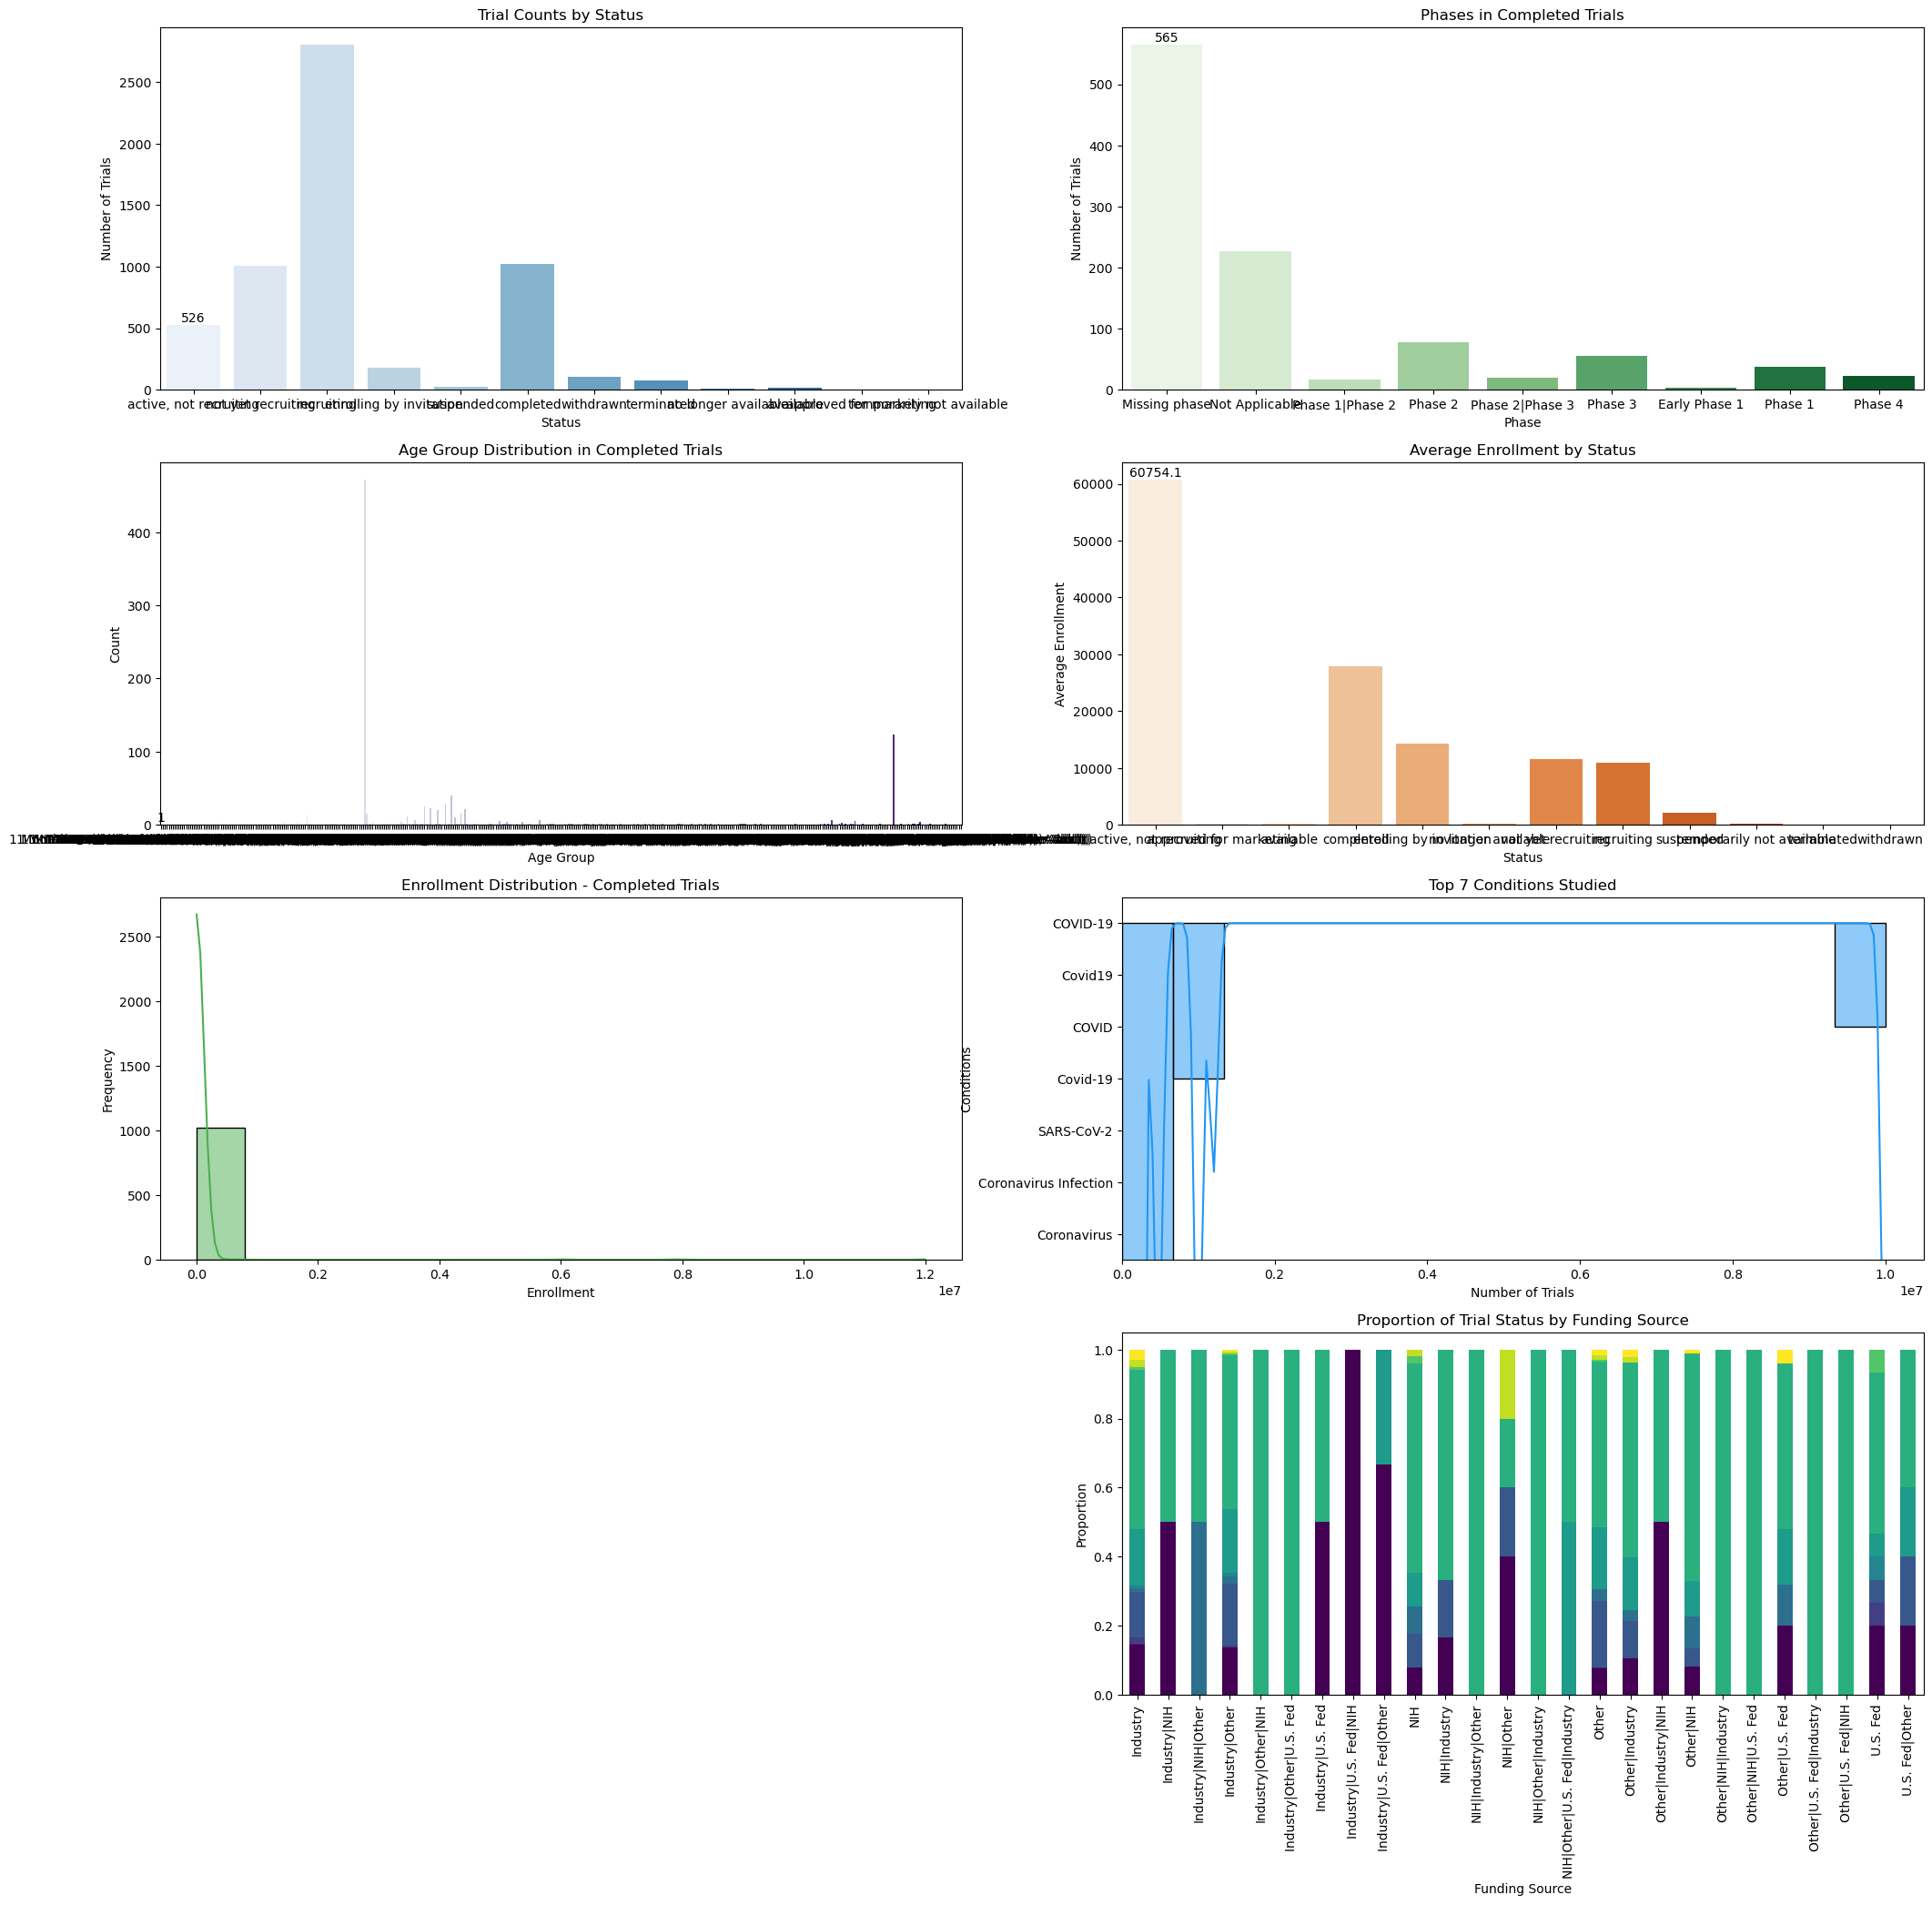

In [9]:
plt.figure(figsize=(25,30))

# Trial Counts by Status
plt.subplot(5,2,1)
ax1 = sns.countplot(x=df['status'], palette='Blues')
ax1.bar_label(ax1.containers[0])
plt.title('Trial Counts by Status')
plt.xlabel('Status')
plt.ylabel('Number of Trials')

# Phases in Completed Trials
plt.subplot(5,2,2)
ax2 = sns.countplot(x=completed_trials['phase'], palette='Greens')
ax2.bar_label(ax2.containers[0])
plt.title('Phases in Completed Trials')
plt.xlabel('Phase')
plt.ylabel('Number of Trials')

# Age Group Distribution in Completed Trials
plt.subplot(5,2,3)
ax3 = sns.countplot(x=completed_trials['age_group'], palette='Purples', order=sorted(df['age_group'].unique()))
ax3.bar_label(ax3.containers[0])
plt.title('Age Group Distribution in Completed Trials')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Avg Enrollment by Status
plt.subplot(5,2,4)
ax4 = sns.barplot(x='status', y='enrollment', data=enrollment_status, palette='Oranges')
ax4.bar_label(ax4.containers[0])
plt.title('Average Enrollment by Status')
plt.xlabel('Status')
plt.ylabel('Average Enrollment')

# Enrollment Histograms Completed Trials
plt.subplot(5,2,5)
sns.histplot(completed_trials['enrollment'], bins=15, color='#4CAF50', kde=True)
plt.title('Enrollment Distribution - Completed Trials')
plt.xlabel('Enrollment')
plt.ylabel('Frequency')

# Enrollment Histograms Ongoing Trials
plt.subplot(5,2,6)
sns.histplot(ongoing_trials['enrollment'], bins=15, color='#2196F3', kde=True)
plt.title('Enrollment Distribution - Ongoing Trials')
plt.xlabel('Enrollment')
plt.ylabel('Frequency')

# Top 7 Conditions Studied
sns.barplot(x=top_conditions.values, y=top_conditions.index, palette='mako')
plt.title('Top 7 Conditions Studied')
plt.xlabel('Number of Trials')
plt.ylabel('Conditions')

# Funding Source by Status (as stacked bars)
plt.subplot(5,2,8)
funding_status_norm.plot(kind='bar', stacked=True, colormap='viridis', legend=False, ax=plt.gca())
plt.title('Proportion of Trial Status by Funding Source')
plt.xlabel('Funding Source')
plt.ylabel('Proportion')

In [10]:
# Clean and Save Processed Data
df.to_csv('cleaned_covid_clinical_trials.csv', index=False)

# Machine Learning

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [23]:
# Selecting Features and Target
target = 'status' 
features = ['phase', 'study_type', 'age_group', 'enrollment', 'funding_source', 'gender', 'country']

In [25]:
X = df[features]
y = df[target]

In [27]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

In [29]:
# Preprocessing pipelines
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder',  LabelEncoder())  # LabelEncoder does not work in pipeline, use OneHotEncoder or OrdinalEncoder alternatively
])

In [31]:
from sklearn.preprocessing import OneHotEncoder

In [33]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [35]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [37]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [39]:
# Defining the model pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [45]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['enrollment']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['phase', 'study_type',
                                                   'age_group',
                                                   'funding_source', 'gender',
                                                   'country'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [47]:
# Predict and Evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.5626620570440796
Classification Report:
                            precision    recall  f1-score   support

   active, not recruiting       0.15      0.12      0.13        92
                available       0.40      1.00      0.57         2
                completed       0.37      0.30      0.33       213
  enrolling by invitation       0.25      0.12      0.16        34
      no longer available       0.00      0.00      0.00         3
       not yet recruiting       0.72      0.59      0.65       203
               recruiting       0.61      0.76      0.68       561
                suspended       0.25      0.11      0.15         9
temporarily not available       0.00      0.00      0.00         1
               terminated       0.17      0.06      0.09        16
                withdrawn       1.00      0.96      0.98        23

                 accuracy                           0.56      1157
                macro avg       0.36      0.37      0.34      1157
       